In [3]:
!pip install --upgrade tensorflow tensorflow-datasets


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.60E8M1_2.0.0/patch_camelyon-test.tfrecord*...:  …

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.60E8M1_2.0.0/patch_camelyon-train.tfrecord*...: …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.60E8M1_2.0.0/patch_camelyon-validation.tfrecord*…

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.
Dataset Info:
tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_dir='/root/tensorflow_datasets/patch_camelyon/2.0.0',
    file_format=tfrecord,
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shap

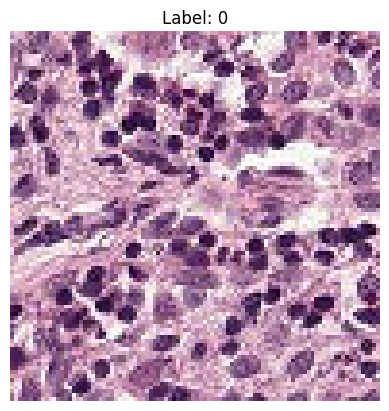

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Set seed for reproducibility
tf.random.set_seed(42)


# Enable memory growth for GPUs (avoid crashes)
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Load PatchCamelyon dataset efficiently
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'patch_camelyon',
    split=['train[:80%]', 'train[80%:]', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Verify loaded dataset
print(f"Dataset Info:\n{ds_info}")

# Example: view a sample image
import matplotlib.pyplot as plt

def show_sample(image, label):
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')

for image, label in ds_train.take(1):
    show_sample(image, label)


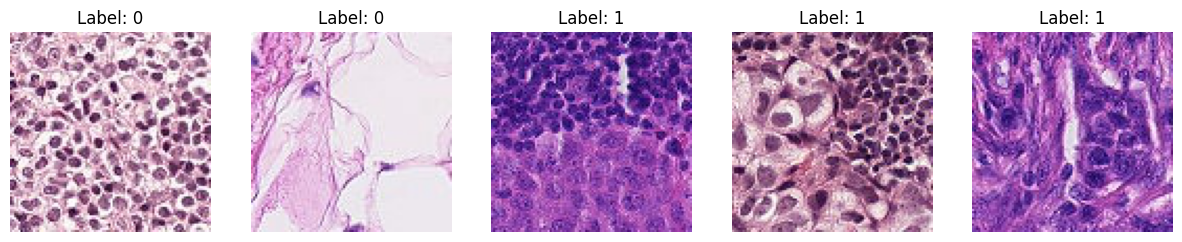

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
ds_train, ds_info = tfds.load('patch_camelyon', split='train', with_info=True, as_supervised=True)

# Display 5 sample images with labels
plt.figure(figsize=(15, 3))
for i, (image, label) in enumerate(ds_train.take(5)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.numpy())
    plt.title(f'Label: {label.numpy()}')
    plt.axis('off')

plt.show()


tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_dir='/root/tensorflow_datasets/patch_camelyon/2.0.0',
    file_format=tfrecord,
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(96, 96, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    dis

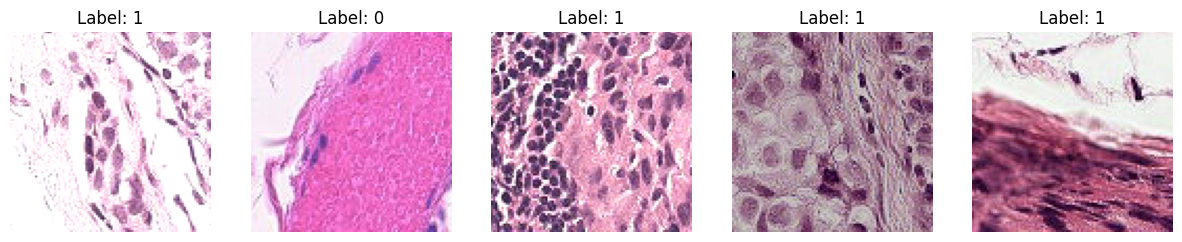

In [6]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Enable GPU memory growth to avoid runtime crashes
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Load PCam dataset with 80% train and 20% test split
(ds_train, ds_test), ds_info = tfds.load(
    'patch_camelyon',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Verify dataset info
print(ds_info)

# Define preprocessing and augmentation functions
def preprocess(image, label):
    # Normalise images to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize images to ensure consistent input size (if required by your models)
    image = tf.image.resize(image, [96, 96])
    return image, label

# Augmentation function according to PDM plan (rotation, flip, contrast)

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.clip_by_value(image, 0.0, 1.0)  # Ensure pixel values are within [0,1]
    return image, label

# Apply preprocessing, augmentation, batching, caching, and prefetching
batch_size = 64

# Training dataset pipeline
ds_train = (
    ds_train
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Test dataset pipeline (no augmentation, just preprocessing)
ds_test = (
    ds_test
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

# Check a batch of training images
for images, labels in ds_train.take(1):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f'Label: {labels[i].numpy()}')
        plt.axis('off')
    plt.show()


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load DenseNet121 model with pretrained weights (imagenet) and custom input shape
base_model = DenseNet121(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Freeze base model layers to leverage pretrained features initially
base_model.trainable = False

# Define the complete model
model_densenet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_densenet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Model summary
model_densenet.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 3, 3, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [11]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss to detect overfitting
    patience=5,              # Stop if no improvement for 5 consecutive epochs
    restore_best_weights=True,  # Restore the best model after early stopping
    verbose=1
)

# Model checkpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_densenet_model.h5',   # Save the model with the best validation performance
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the DenseNet-121 model for 20 epochs with callbacks
history_densenet = model_densenet.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
    callbacks=[early_stopping, model_checkpoint]  # Adding callbacks
)

# Save the final model explicitly (if not already saved by ModelCheckpoint)
model_densenet.save('final_densenet_model.h5')
print("Training complete. Model saved.")


Epoch 1/20
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8046 - auc: 0.8843 - loss: 0.4232
Epoch 1: val_loss improved from inf to 0.35277, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 178s 46ms/step - accuracy: 0.8046 - auc: 0.8843 - loss: 0.4232 - val_accuracy: 0.8465 - val_auc: 0.9236 - val_loss: 0.3528
Epoch 2/20
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8419 - auc: 0.9200 - loss: 0.3599
Epoch 2: val_loss improved from 0.35277 to 0.34555, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 84s 26ms/step - accuracy: 0.8419 - auc: 0.9200 - loss: 0.3599 - val_accuracy: 0.8502 - val_auc: 0.9265 - val_loss: 0.3456
Epoch 3/20
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8446 - auc: 0.9225 - loss: 0.3543
Epoch 3: val_loss improved from 0.34555 to 0.34279, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 108s 33ms/step - accuracy: 0.8446 - auc: 0.9225 - loss: 0.3543 - val_accuracy: 0.8521 - val_auc: 0.9278 - val_loss: 0.3428
Epoch 4/20
3275/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8465 - auc: 0.9243 - loss: 0.3502
Epoch 4: val_loss improved from 0.34279 to 0.33928, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 84s 26ms/step - accuracy: 0.8465 - auc: 0.9243 - loss: 0.3502 - val_accuracy: 0.8531 - val_auc: 0.9292 - val_loss: 0.3393
Epoch 5/20
3274/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8475 - auc: 0.9253 - loss: 0.3477
Epoch 5: val_loss improved from 0.33928 to 0.33896, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 108s 33ms/step - accuracy: 0.8475 - auc: 0.9253 - loss: 0.3477 - val_accuracy: 0.8536 - val_auc: 0.9294 - val_loss: 0.3390
Epoch 6/20
3276/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8484 - auc: 0.9259 - loss: 0.3464
Epoch 6: val_loss improved from 0.33896 to 0.33639, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 85s 26ms/step - accuracy: 0.8484 - auc: 0.9259 - loss: 0.3464 - val_accuracy: 0.8546 - val_auc: 0.9304 - val_loss: 0.3364
Epoch 7/20
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8489 - auc: 0.9264 - loss: 0.3453
Epoch 7: val_loss improved from 0.33639 to 0.33626, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 106s 32ms/step - accuracy: 0.8489 - auc: 0.9264 - loss: 0.3453 - val_accuracy: 0.8538 - val_auc: 0.9308 - val_loss: 0.3363
Epoch 8/20
3276/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8497 - auc: 0.9267 - loss: 0.3447
Epoch 8: val_loss did not improve from 0.33626
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 94s 29ms/step - accuracy: 0.8497 - auc: 0.9267 - loss: 0.3447 - val_accuracy: 0.8533 - val_auc: 0.9303 - val_loss: 0.3381
Epoch 9/20
3275/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8506 - auc: 0.9274 - loss: 0.3429
Epoch 9: val_loss did not improve from 0.33626
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 96s 29ms/step - accuracy: 0.8506 - auc: 0.9274 - loss: 0.3429 - val_accuracy: 0.8417 - val_auc: 0.9301 - val_loss: 0.3584
Epoch 10/20
3276/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8503 - auc: 0.9276 - loss: 0.3426
Epoch 10: val_loss did not improve from 0.33626
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 101s 31ms/step - accuracy: 0.8503 - auc: 0.9276 - loss: 0

3277/3277 ━━━━━━━━━━━━━━━━━━━━ 89s 27ms/step - accuracy: 0.8503 - auc: 0.9278 - loss: 0.3420 - val_accuracy: 0.8549 - val_auc: 0.9316 - val_loss: 0.3346
Epoch 12/20
3276/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8515 - auc: 0.9282 - loss: 0.3411
Epoch 12: val_loss improved from 0.33463 to 0.33280, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - accuracy: 0.8515 - auc: 0.9282 - loss: 0.3411 - val_accuracy: 0.8559 - val_auc: 0.9321 - val_loss: 0.3328
Epoch 13/20
3276/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8514 - auc: 0.9283 - loss: 0.3409
Epoch 13: val_loss did not improve from 0.33280
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 83s 25ms/step - accuracy: 0.8514 - auc: 0.9283 - loss: 0.3409 - val_accuracy: 0.8553 - val_auc: 0.9309 - val_loss: 0.3356
Epoch 14/20
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8521 - auc: 0.9286 - loss: 0.3403
Epoch 14: val_loss improved from 0.33280 to 0.33277, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - accuracy: 0.8521 - auc: 0.9286 - loss: 0.3403 - val_accuracy: 0.8559 - val_auc: 0.9324 - val_loss: 0.3328
Epoch 15/20
3274/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8516 - auc: 0.9291 - loss: 0.3390
Epoch 15: val_loss improved from 0.33277 to 0.33145, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 84s 26ms/step - accuracy: 0.8516 - auc: 0.9291 - loss: 0.3390 - val_accuracy: 0.8563 - val_auc: 0.9327 - val_loss: 0.3314
Epoch 16/20
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8521 - auc: 0.9290 - loss: 0.3393
Epoch 16: val_loss improved from 0.33145 to 0.33047, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - accuracy: 0.8521 - auc: 0.9290 - loss: 0.3393 - val_accuracy: 0.8579 - val_auc: 0.9328 - val_loss: 0.3305
Epoch 17/20
3274/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8522 - auc: 0.9292 - loss: 0.3388
Epoch 17: val_loss did not improve from 0.33047
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 84s 26ms/step - accuracy: 0.8522 - auc: 0.9292 - loss: 0.3388 - val_accuracy: 0.8561 - val_auc: 0.9323 - val_loss: 0.3326
Epoch 18/20
3275/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8523 - auc: 0.9292 - loss: 0.3386
Epoch 18: val_loss did not improve from 0.33047
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 106s 32ms/step - accuracy: 0.8523 - auc: 0.9292 - loss: 0.3386 - val_accuracy: 0.8558 - val_auc: 0.9329 - val_loss: 0.3329
Epoch 19/20
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8524 - auc: 0.9294 - loss: 0.3384
Epoch 19: val_loss improved from 0.33047 to 0.32888, saving model to best_densenet_model.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 88s 27ms/step - accuracy: 0.8524 - auc: 0.9294 - loss: 0.3384 - val_accuracy: 0.8589 - val_auc: 0.9335 - val_loss: 0.3289
Epoch 20/20
3275/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8533 - auc: 0.9297 - loss: 0.3375
Epoch 20: val_loss did not improve from 0.32888
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 101s 31ms/step - accuracy: 0.8533 - auc: 0.9297 - loss: 0.3375 - val_accuracy: 0.8536 - val_auc: 0.9334 - val_loss: 0.3357
Restoring model weights from the end of the best epoch: 19.


Training complete. Model saved.


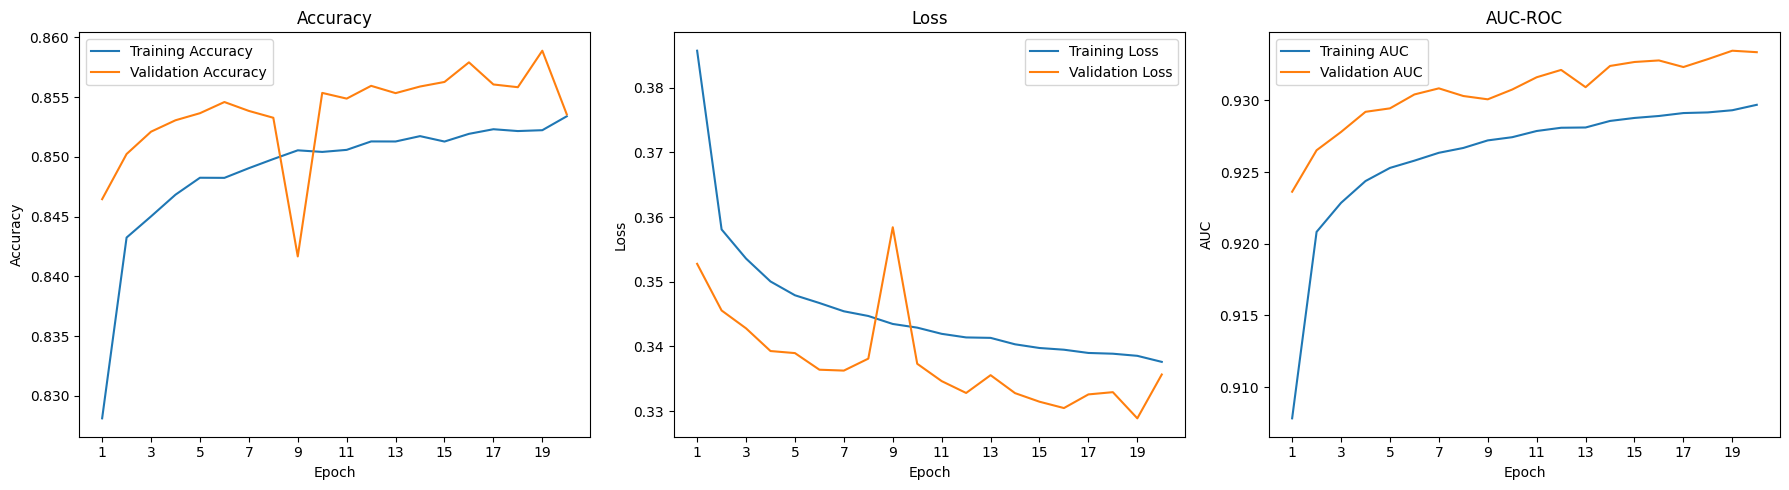

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to plot training curves with spaced x-axis
def plot_training_curves(history):
    epochs = np.arange(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(18, 5))

    # Accuracy Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, len(epochs) + 1, step=2))  # Spaced x-axis
    plt.legend()

    # Loss Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, len(epochs) + 1, step=2))  # Spaced x-axis
    plt.legend()

    # AUC-ROC Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history.history['auc'], label='Training AUC')
    plt.plot(epochs, history.history['val_auc'], label='Validation AUC')
    plt.title('AUC-ROC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.xticks(np.arange(1, len(epochs) + 1, step=2))  # Spaced x-axis
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to evaluate the model
def evaluate_model(model, dataset):
    y_true, y_pred = [], []
    for images, labels in dataset:
        predictions = model.predict(images)
        predictions = np.round(predictions).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(predictions)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    print("\nDenseNet-121 Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

# Plot training curves and evaluate the model after 20 epochs
plot_training_curves(history_densenet)
evaluate_model(model_densenet, ds_test)


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load DenseNet121 model with pretrained weights (ImageNet) and custom input shape
base_model = DenseNet121(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Unfreeze all layers in the base model for fine-tuning
base_model.trainable = True

# Define the complete model
model_densenet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with a low learning rate for fine-tuning
model_densenet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Early stopping to prevent overfitting and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    'best_densenet_finetune.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Fine-tune the model for additional 10 epochs
history_finetune = model_densenet.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model after fine-tuning
model_densenet.save('densenet_finetuned.h5')
print("Model saved after fine-tuning!")


Epoch 1/10
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8258 - auc: 0.9049 - loss: 0.3889
Epoch 1: val_loss improved from inf to 0.18788, saving model to best_densenet_finetune.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 591s 108ms/step - accuracy: 0.8258 - auc: 0.9049 - loss: 0.3889 - val_accuracy: 0.9272 - val_auc: 0.9784 - val_loss: 0.1879
Epoch 2/10
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9272 - auc: 0.9781 - loss: 0.1868
Epoch 2: val_loss improved from 0.18788 to 0.14690, saving model to best_densenet_finetune.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 213s 65ms/step - accuracy: 0.9272 - auc: 0.9781 - loss: 0.1868 - val_accuracy: 0.9445 - val_auc: 0.9858 - val_loss: 0.1469
Epoch 3/10
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9511 - auc: 0.9884 - loss: 0.1337
Epoch 3: val_loss improved from 0.14690 to 0.13111, saving model to best_densenet_finetune.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 214s 65ms/step - accuracy: 0.9511 - auc: 0.9884 - loss: 0.1337 - val_accuracy: 0.9512 - val_auc: 0.9883 - val_loss: 0.1311
Epoch 4/10
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9650 - auc: 0.9937 - loss: 0.0977
Epoch 4: val_loss improved from 0.13111 to 0.12928, saving model to best_densenet_finetune.h5


3277/3277 ━━━━━━━━━━━━━━━━━━━━ 221s 67ms/step - accuracy: 0.9650 - auc: 0.9937 - loss: 0.0977 - val_accuracy: 0.9546 - val_auc: 0.9887 - val_loss: 0.1293
Epoch 5/10
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9754 - auc: 0.9968 - loss: 0.0702
Epoch 5: val_loss did not improve from 0.12928
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 217s 66ms/step - accuracy: 0.9754 - auc: 0.9968 - loss: 0.0702 - val_accuracy: 0.9536 - val_auc: 0.9882 - val_loss: 0.1361
Epoch 6/10
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9844 - auc: 0.9985 - loss: 0.0470
Epoch 6: val_loss did not improve from 0.12928
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 209s 64ms/step - accuracy: 0.9844 - auc: 0.9985 - loss: 0.0470 - val_accuracy: 0.9546 - val_auc: 0.9871 - val_loss: 0.1454
Epoch 7/10
3276/3277 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9893 - auc: 0.9993 - loss: 0.0329
Epoch 7: val_loss did not improve from 0.12928
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 209s 64ms/step - accuracy: 0.9893 - auc: 0.9993 - loss: 0

Model saved after fine-tuning!


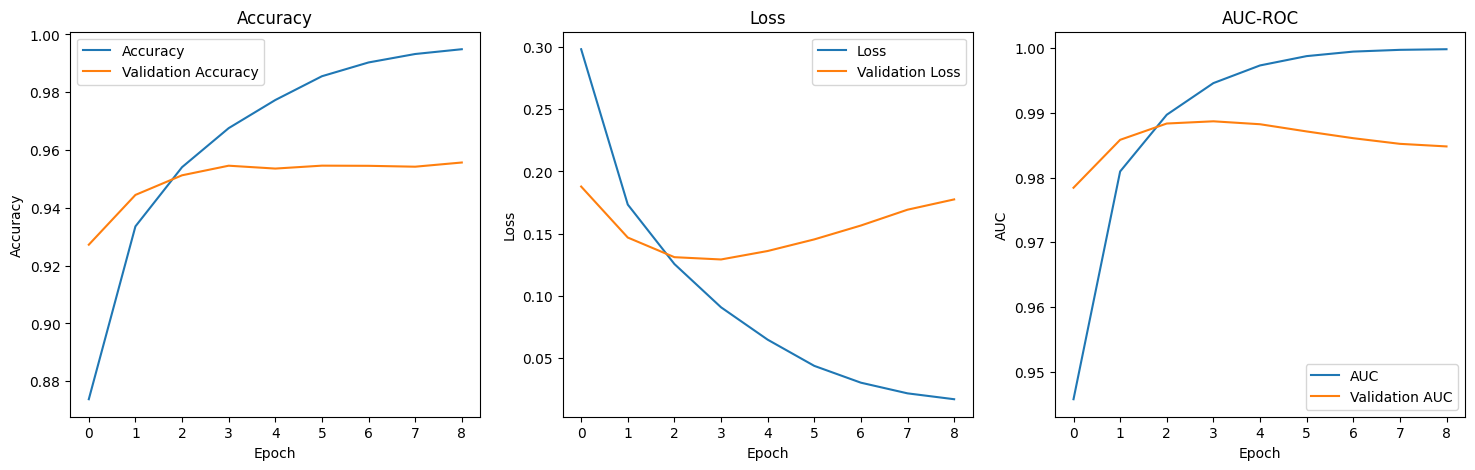

2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━

In [14]:
# Required imports for visualisation and evaluation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Plot training curves after fine-tuning
def plot_training_curves(history):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC-ROC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.show()

# Evaluate model performance on test data
def evaluate_model(model, dataset):
    y_true, y_pred = [], []
    for images, labels in dataset:
        predictions = model.predict(images)
        predictions = np.round(predictions).astype(int)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.flatten())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    print("\nModel Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

# Run these functions after fine-tuning
plot_training_curves(history_finetune)
evaluate_model(model_densenet, ds_test)


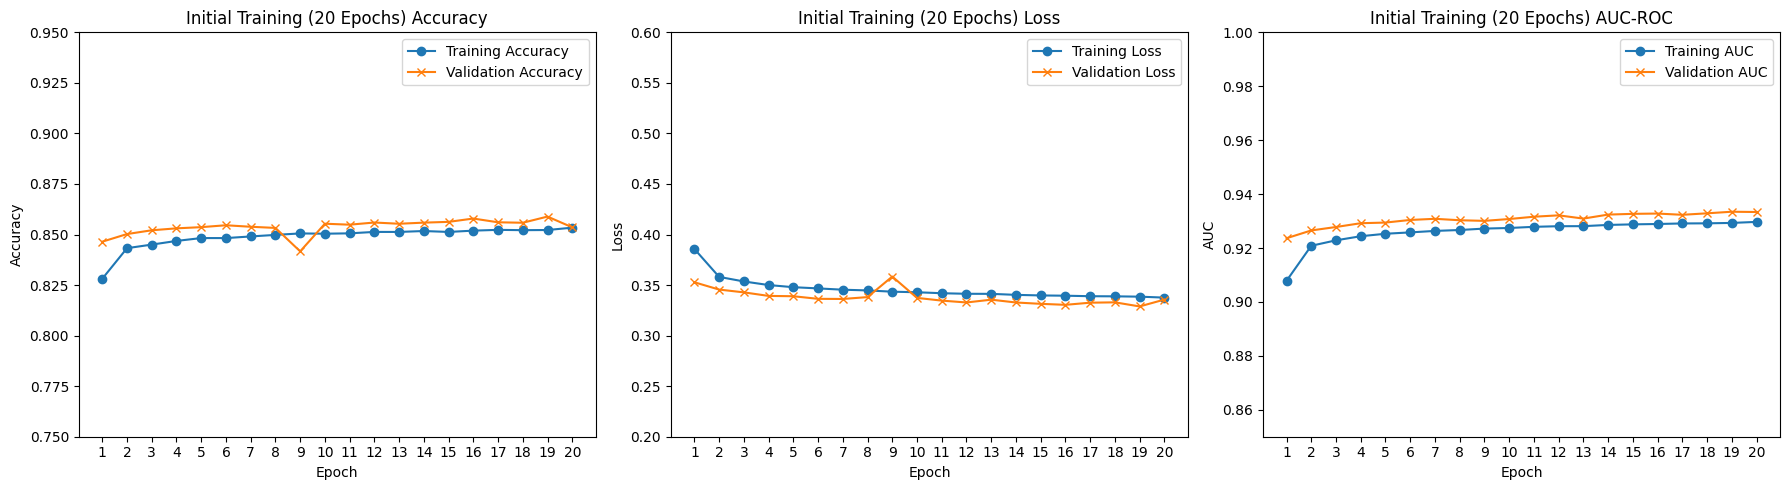

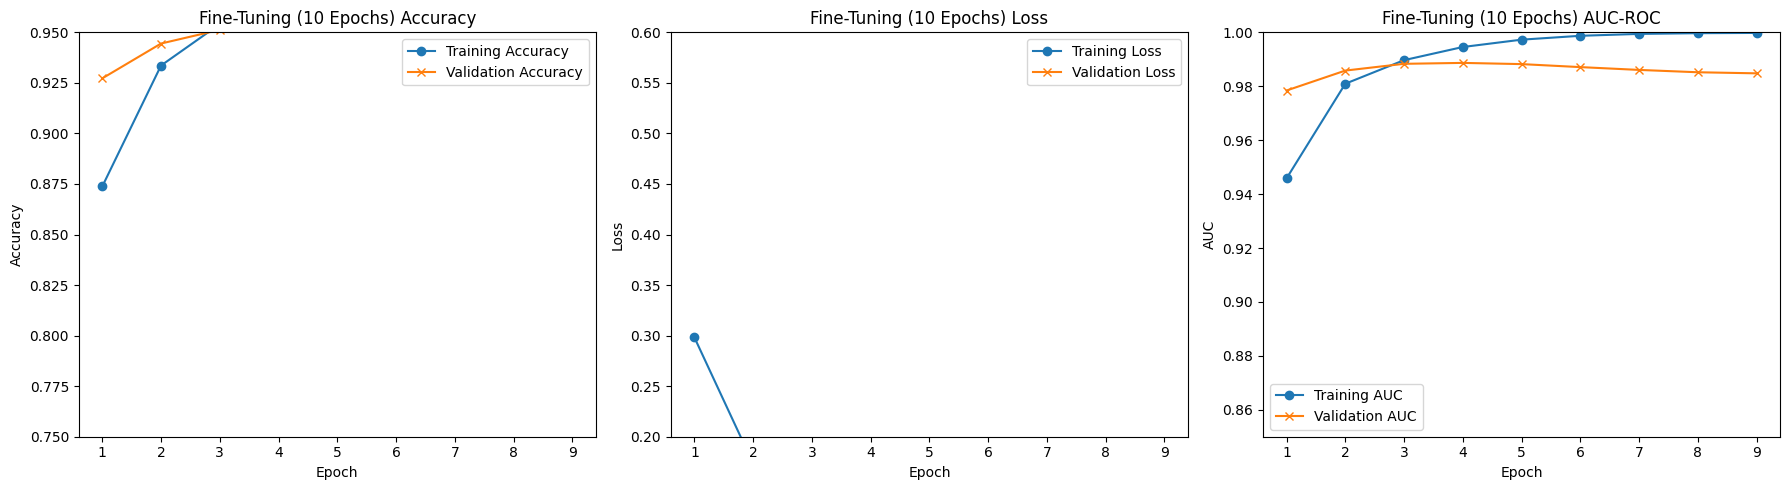

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━

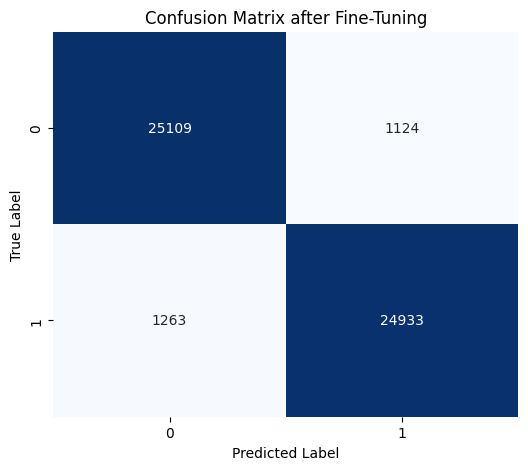

In [15]:
# Required imports for visualisation and evaluation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Plot training curves for each phase separately
def plot_training_curves(history, title_prefix=""):
    epochs = np.arange(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(18, 5))

    # Accuracy Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='x')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, len(epochs) + 1, step=1))
    plt.ylim(0.75, 0.95)
    plt.legend()

    # Loss Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='x')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, len(epochs) + 1, step=1))
    plt.ylim(0.2, 0.6)
    plt.legend()

    # AUC-ROC Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history.history['auc'], label='Training AUC', marker='o')
    plt.plot(epochs, history.history['val_auc'], label='Validation AUC', marker='x')
    plt.title(f'{title_prefix} AUC-ROC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.xticks(np.arange(1, len(epochs) + 1, step=1))
    plt.ylim(0.85, 1.0)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluate model performance on test data
def evaluate_model(model, dataset):
    y_true, y_pred = [], []
    for images, labels in dataset:
        predictions = model.predict(images)
        predictions = np.round(predictions).astype(int)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.flatten())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    print("\nModel Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    return y_true, y_pred

# Plot confusion matrix for evaluation
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot training curves separately for initial and fine-tuning phases
if 'history_densenet' in globals():
    plot_training_curves(history_densenet, title_prefix="Initial Training (20 Epochs)")

if 'history_finetune' in globals():
    plot_training_curves(history_finetune, title_prefix="Fine-Tuning (10 Epochs)")

# Run evaluation
y_true, y_pred = evaluate_model(model_densenet, ds_test)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix after Fine-Tuning")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━

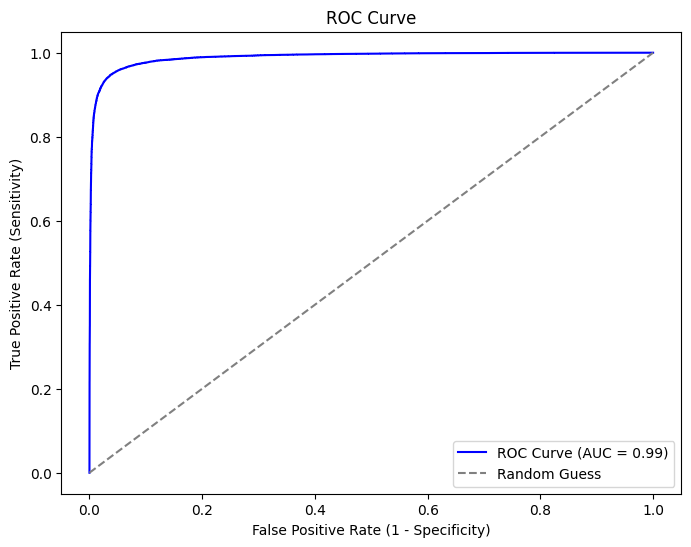

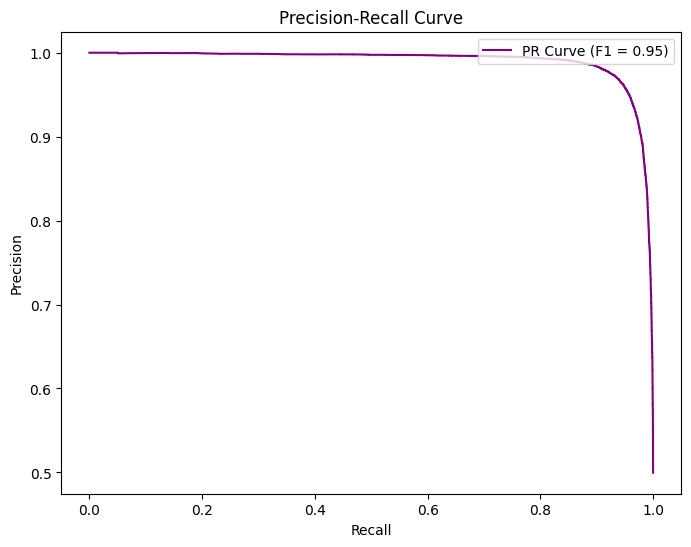

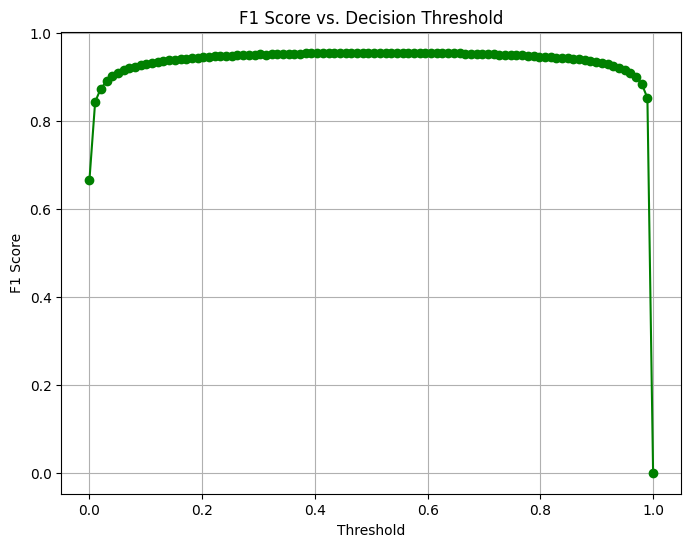

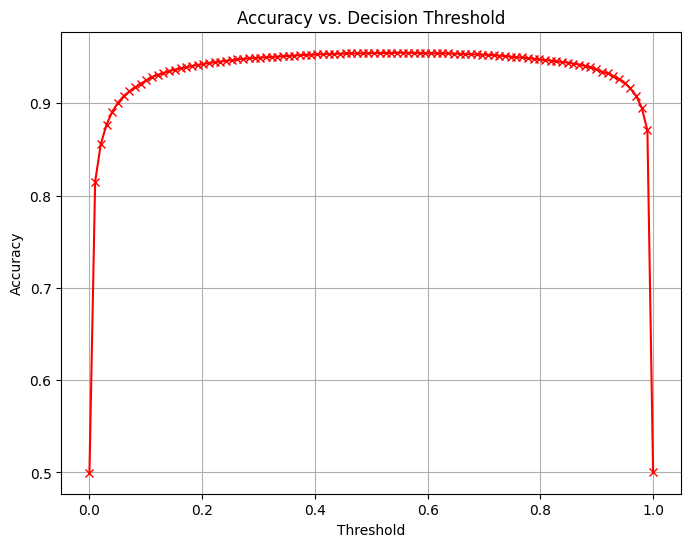

In [16]:
# Required imports for advanced evaluation plots
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, accuracy_score

def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    f1 = f1_score(y_true, np.round(y_pred_prob))

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', label=f'PR Curve (F1 = {f1:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.show()

def plot_f1_vs_threshold(y_true, y_pred_prob):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_true, y_pred_prob >= t) for t in thresholds]

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores, marker='o', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Decision Threshold')
    plt.grid(True)
    plt.show()

def plot_accuracy_vs_threshold(y_true, y_pred_prob):
    thresholds = np.linspace(0, 1, 100)
    accuracies = [accuracy_score(y_true, y_pred_prob >= t) for t in thresholds]

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, accuracies, marker='x', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Decision Threshold')
    plt.grid(True)
    plt.show()

# Evaluation function to get true labels and predicted probabilities
def get_predictions(model, dataset):
    y_true, y_pred_prob = [], []
    for images, labels in dataset:
        preds = model.predict(images).flatten()
        y_true.extend(labels.numpy())
        y_pred_prob.extend(preds)
    return np.array(y_true), np.array(y_pred_prob)

# Get predictions from the model
y_true, y_pred_prob = get_predictions(model_densenet, ds_test)

# Plot the advanced evaluation curves
plot_roc_curve(y_true, y_pred_prob)
plot_precision_recall_curve(y_true, y_pred_prob)
plot_f1_vs_threshold(y_true, y_pred_prob)
plot_accuracy_vs_threshold(y_true, y_pred_prob)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


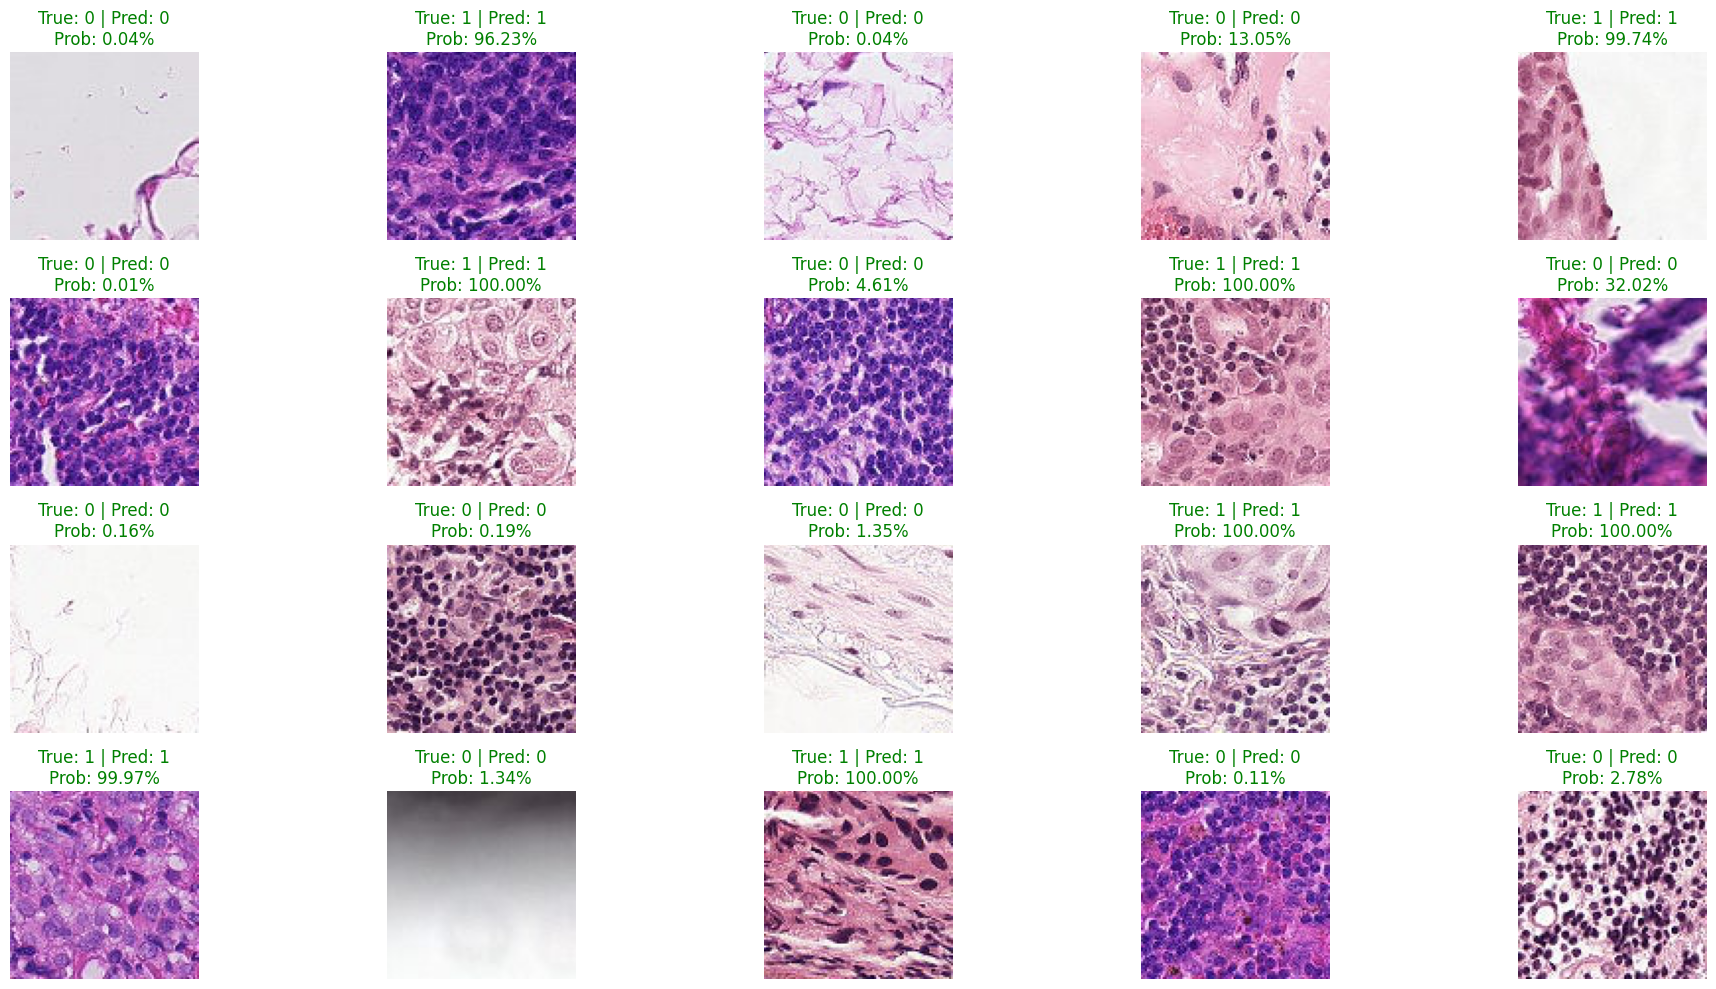

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualise predictions on a subset of images
def visualize_predictions(model, dataset, num_images=20):
    plt.figure(figsize=(20, 10))
    images_shown = 0

    for images, labels in dataset:
        predictions = model.predict(images)
        preds_rounded = np.round(predictions).astype(int).flatten()
        preds_probs = predictions.flatten()

        for i in range(images.shape[0]):
            plt.subplot(4, 5, images_shown + 1)
            plt.imshow(images[i].numpy())
            true_label = labels.numpy()[i]
            pred_label = preds_rounded[i]
            pred_prob = preds_probs[i]

            # Title includes true label, predicted label, and prediction confidence
            plt.title(f"True: {true_label} | Pred: {pred_label}\nProb: {pred_prob:.2%}",
                      color="green" if true_label == pred_label else "red")
            plt.axis('off')
            images_shown += 1

            if images_shown >= num_images:
                plt.tight_layout()
                plt.show()
                return

# Visualise model predictions on 20 test images
visualize_predictions(model_densenet, ds_test)
